# Clustering of Trajectories under Global Confounding

In [1]:
#optimal transport library
import ot

#exotic clustering algorithm, TDA
from tomaster import tomato
#from gudhi.clustering.tomato import Tomato

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

#backtester
#import bt

#machine learning library for time series
import tslearn
import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import ray
import datetime

import pyvinecopulib as pv

import os
import warnings
warnings.filterwarnings("ignore")

#import tensorflow as tf
#import tensorflow.experimental.numpy as tnp
#tnp.experimental_enable_numpy_behavior()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

import confound_mdp
import confound_ope
import confound_env

#from core.sepsisSimDiabetes.State import State
#from core.sepsisSimDiabetes.Action import Action
#from core import generator_confounded_mdp as DGEN
#from core import conf_wis as CWIS
#from core import loss_minimization as LB
from utils.utils import *

import copy

%matplotlib inline
plt.style.use('matplotlibrc')

/Users/hetankevin/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [48]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]

pi_b, P, R, x_dist, u_dist, gamma = confound_env.toyH2(0.6, 0.7, 0.8)
toyH2 = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
horizon = 50
nStates = P.shape[2]
nActions = P.shape[1]
pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([toyH2, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

pi_b, P, R, x_dist, u_dist, gamma = confound_env.toy227(0.25, 0.35)
toy = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
horizon = 5
nStates = P.shape[2]
nActions = P.shape[1]
pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([toy, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

horizon = 4
graph_len = 4
pi_b, P, R, x_dist, u_dist, gamma = confound_env.graph_opetools(horizon=graph_len, slip=0.25, confound_weight=0.23)
R = -1*R
graph = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([graph, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

horizon = 20
pi_b, P, R, x_dist, u_dist, gamma = confound_env.toymc_opetools(n_left=8, n_right=8, horizon=20, slip=0.15, confound_weight=0.6)
#R = -1*R
toymc = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.15, 0.85]
    
envs.append([toymc, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])

horizon = 18
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, confound_weight=0.6)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])



In [49]:
fqe_envs = []
mb_envs = []

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

#hadds = [0, 5, 10]
hadds = [0]

for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in [envs[-1]]:
    
    print("---")
    
    for h in hadds:
        horizon = base_horizon + h
        
        print("running env with horizon " + str(horizon))

        dataset = confound_mdp.collect_sample(int(30000/horizon), mdp, pi_b, horizon, iid=False)
        data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
        Phat = confound_ope.estimate_P(dataset, mdp)
        pihat = confound_ope.estimate_pi(dataset, mdp)
        for a in range(nActions):
            for s in range(nStates):
                if Phat[a,s].sum() == 0:
                    Phat[a,s,term] = 1
                if pihat[s].sum() == 0:
                    pihat[s,:] = 1/nActions
        pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]
        
        # This is the actual reward_sa
        # P(s,a,s') * R(s,a,s')
        # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
        R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
        P_spsa = Phat.transpose((2, 1, 0))
        n = data.shape[0]
        

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())

        '''
        # no confounding:
        print("value of pi_e with no confounding")
        Q0 = np.zeros((nStates, nActions))
        nom_q = Q0.copy()
        for t in range(horizon):
            nom_q = fitted_q_update(nom_q, pi_e, dataset, mdp)
        print(mdp.get_value(nom_q,pi_e)[1])

        fqe_results = []

        print("now running C-FQE")
        for i,gam in enumerate(gams):
            Q0 = np.zeros((nStates, nActions))
            q_reparam_samp = Q0.copy()
            for t in range(horizon):
                q_reparam_samp = fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pihat, Pb_spsa, gam, R_sa, data, mdp)
            fqe_results.append(mdp.get_value(q_reparam_samp,pi_e)[0])
            
        '''

        '''
        print("now running robust mdps...")
        mb_results = np.zeros((nGams, nPbs))

        for i,gam in tqdm(enumerate(gams)):
            for j,P_bound in enumerate(Pbs):
                V0 = np.zeros(nStates)
                fixed_u_v = V0.copy()
                for t in range(horizon):
                    fixed_u_v = confound_ope.fixed_u_gp_s_rect(fixed_u_v, pi_e, 0.50, Phat, pihat, P_bound, gam, mdp)
                mb_results[i,j] = fixed_u_v @ mdp.x_dist

        fqe_envs.append(fqe_results)
        mb_envs.append(mb_results)
        '''

---
running env with horizon 18
value of pi_b
-0.6009379371627832


## Method 1: PCA >%> ToMATo Clustering >%> t-SNE

In [50]:
# x, a, u, x', r
dataset.shape

(1666, 18, 5)

In [62]:
stateactions = dataset[:, :, [0, 1]]
X = stateactions.reshape(stateactions.shape[0], stateactions.shape[1]*stateactions.shape[2])
fullX = dataset.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2])

from sklearn.decomposition import PCA
pca = PCA(n_components=10, whiten=False).fit_transform(X)

In [63]:
threes = dataset.reshape(int(dataset.shape[0] * dataset.shape[1] / 3), 3, dataset.shape[2])
stateactions = threes[:,:,0] + threes[:,:,1]*nStates #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
confounders = threes[:,:,2]
labels = confounders[:,0]
nextstates = threes[:,:,3]

In [65]:
stateactions[:,0]

(9996, 3)

In [54]:
confounders

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [22]:
from gudhi.clustering.tomato import Tomato
t = Tomato(density_type='logDTM', metric='euclidean', k=int(len(X)/5))
t.fit(pca)
t.plot_diagram()
np.unique(t.labels_)
plt.hist(np.sort(np.bincount(t.labels_)))
clusterLabs = t.labels_

ModuleNotFoundError: No module named 'gudhi'

NameError: name 't' is not defined

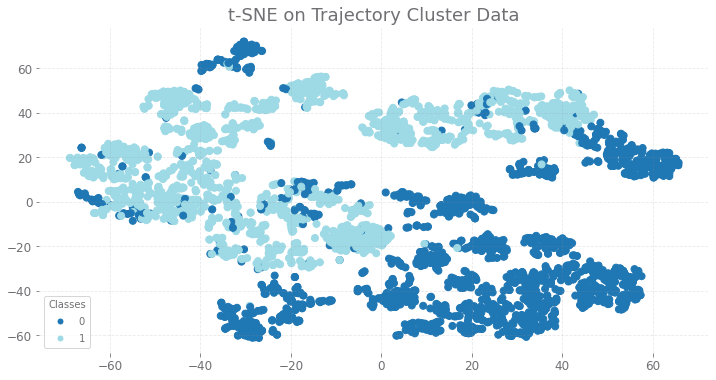

In [45]:
tsne = sklearn.manifold.TSNE(n_components=2, metric='euclidean').fit_transform(pca)
fig, ax = plt.subplots(figsize=(12,6))

scatter = ax.scatter(tsne[:,0], tsne[:, 1], c=labels, cmap='tab20')
ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.set_title("t-SNE on Trajectory Cluster Data")
print(np.bincount(t.labels_))

Text(0.5, 1.0, 'PCA on Trajectories')

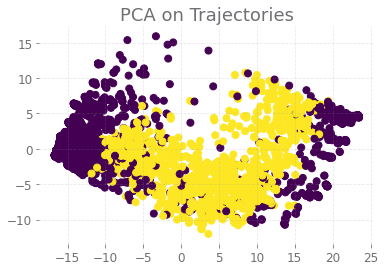

In [44]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2, whiten=False).fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(pca2[:,0], pca2[:, 1], c=labels)
ax.set_title("PCA on Trajectories")

In [97]:
for label in np.unique(t.labels_):
    print(np.bincount(fullX[t.labels_ == label,2::5].flatten().astype(int)))

[11472  5344]
[3440 9744]


In [10]:
t.labels_

array([15, 12,  6, ..., 11,  7,  7], dtype=int32)

## Method 2: Dynamic Time Warping %>% Clustering %>% t-SNE

In [85]:
from tslearn.metrics import dtw
from tqdm import tqdm

dist_mat = np.zeros((X.shape[0], X.shape[0]))
for i in tqdm(range(len(dist_mat))):
    for j in range(len(dist_mat)):
        if i < j:
            dist_mat[i, j] = tslearn.metrics.dtw(X[i], X[j])
            dist_mat[j, i] = dist_mat[i, j]

100%|██████████| 3750/3750 [04:39<00:00, 13.40it/s] 


In [21]:
#np.save('dtwTrajGrid8.npy', dist_mat)
dist_mat = np.load('dtwTrajGrid8.npy')

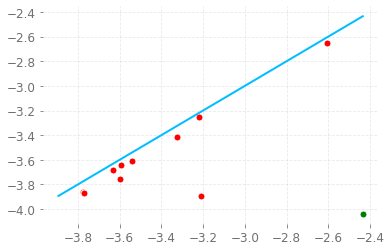

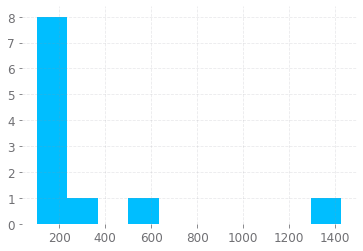

In [103]:
from gudhi.clustering.tomato import Tomato
dtwt = Tomato(density_type='logDTM', metric='precomputed', k=int(len(X)/50))
dtwt.fit(dist_mat)
dtwt.plot_diagram()
np.unique(dtwt.labels_)
plt.hist(np.sort(np.bincount(dtwt.labels_)))
clusterLabs = dtwt.labels_

Text(0.5, 1.0, 't-SNE on Trajectory Cluster Data')

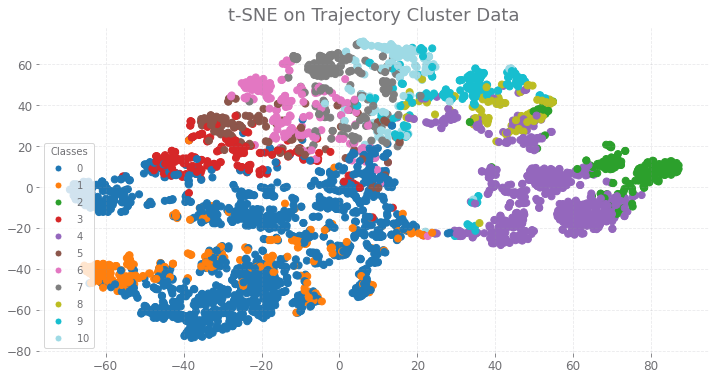

In [104]:
#dtwtsne = sklearn.manifold.TSNE(n_components=2, metric='precomputed').fit_transform(dist_mat)
fig, ax = plt.subplots(figsize=(12,6))

scatter = ax.scatter(dtwtsne[:,0], dtwtsne[:, 1], c=dtwt.labels_, cmap='tab20')
ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.set_title("t-SNE on Trajectory Cluster Data")

In [107]:
np.bincount(dtwt.labels_)

array([1427,  264,  191,  209,  606,  143,  222,  216,  104,  201,  167])

## Method 3: Computing Sample Transition Matrices & Taking L1 Norm

In [82]:
Phats = []
for i in range(len(dataset)):
    Phats.append(confound_ope.estimate_P(np.array([dataset[i]]), gridworld))
Phats = np.array(Phats)
Phats = Phats.reshape((Phats.shape[0], -1))

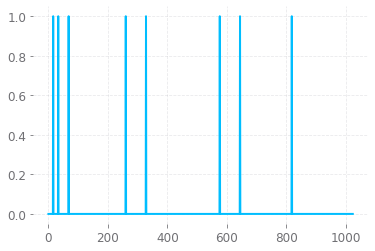

In [118]:
plt.plot(Phats[-1])

In [83]:
Phats.shape

(3750, 1024)

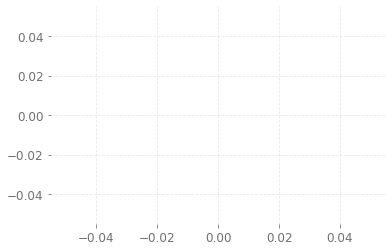

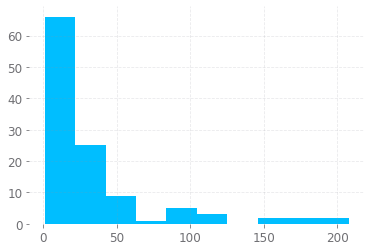

In [108]:
from gudhi.clustering.tomato import Tomato
tnorm = Tomato(density_type='logDTM', metric='manhattan', k=int(len(X)/100))
tnorm.fit(Phats)
tnorm.plot_diagram()
np.unique(tnorm.labels_)
plt.hist(np.sort(np.bincount(tnorm.labels_)))
clusterLabs = tnorm.labels_

In [97]:
np.bincount(tnorm.labels_)

array([3730,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1])

Text(0.5, 1.0, 't-SNE on Trajectory Cluster Data')

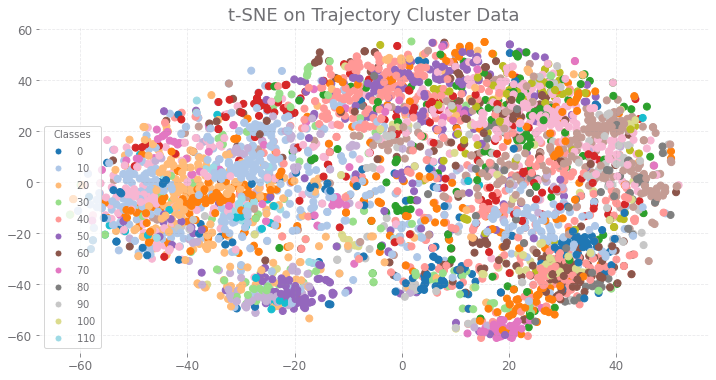

In [110]:
#tsnenorm = sklearn.manifold.TSNE(n_components=2, metric='manhattan').fit_transform(Phats)
fig, ax = plt.subplots(figsize=(12,6))

scatter = ax.scatter(tsnenorm[:,0], tsnenorm[:, 1], c=tnorm.labels_, cmap='tab20')
ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.set_title("t-SNE on Trajectory Cluster Data")

Text(0.5, 1.0, 'PCA on Trajectories')

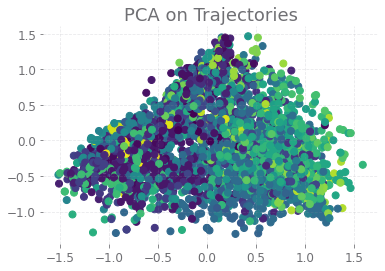

In [111]:
pcanorm = PCA(n_components=2, whiten=False).fit_transform(Phats)
fig, ax = plt.subplots()
ax.scatter(pcanorm[:,0], pcanorm[:, 1], c=tnorm.labels_)
ax.set_title("PCA on Trajectories")